# Pinky and the Brain: Transforming and Translating Neural Activity with Neural Networks

Predicting mice behavior by translating neural data encoding to behavioral decodings. 

*note: the following are packages used in this project.*

In [13]:
import math
import sys
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from Transformer import Transformer
from positional_encoding import PositionalEncoding
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from roc_auc import cal_auc

## The Plan: 
Our model is based on an article that analyzes the continuous behavior of mice in a free-roam environment. Precisely, mice are placed into an operant box where if a lever is pressed for a certain threshold of duration (800ms) then the mouse is rewarded with sucrose or food pellets. Behavioral data is collected regarding the number of successful lever presses and the duration of each lever press. Neural data is also recorded in terms of intracellular calcium ion concetration via GCaMP protein photometry. 

Because both behavioral and neural data are time-series data that share many similarities with sequntial data that is commonly processed with transformer models, we propose to construct a encoder-decoder transformer model to: 
1. predict the subsequence sequence of neural activity given previous neural recordings. 
2. Translate abstract neural data prediction in to concrete behavioral predictions via a sigmoid classifier.

## The Data
Our input data takes the form of both neural and behavioral time sereis data. Specifically, we use lever press duration as the behavioral component input while we use the corresponding GCaMP protein recording per second for the neural component input.

## The Transformer Model

### Positional Embedding

In [14]:
class PositionalEncoding(
    nn.Module,
):
    # needs to go at the bottom of the encoder and decoder stacks
    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 3000):
        super().__init__()

        # Hyperparameter: to introduce regularization that prevents against overfitting
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        pe = torch.squeeze(pe)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :].requires_grad_(False)
        return self.dropout(x)

### Encoder & Decoder
The encoder-decoder model will take neural data as encoding input and behavioral data as decoder input. 

In [15]:
class Transformer(nn.Module):

    # input var
    def __init__(
        self,
        num_input_variables,
        dim_val,
        encoder_dim_feedforward_d_model_scalar,
        encoder_dropout,
        encoder_num_layers,
        encoder_activation,
        encoder_num_heads,
        decoder_dim_feedforward_d_model_scalar,
        decoder_dropout,
        decoder_num_layers,
        decoder_num_heads,
        decoder_activation,
        max_seq,
    ):

        super().__init__()

        self.encoder_input_layer = nn.Linear(in_features=max_seq, out_features=dim_val)

        self.positional_encoding = PositionalEncoding(dim_val, max_len=max_seq)

        # dim_feedforward must be a scalar of d_model value
        # dropout: since a larger dropout is needed within the hidden layers, ensure that it can be up to .5
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val,
            nhead=encoder_num_heads,
            dim_feedforward=dim_val * encoder_dim_feedforward_d_model_scalar,
            dropout=encoder_dropout,
            activation=encoder_activation,
        )

        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=encoder_num_layers)

        self.decoder_input_layer = nn.Linear(in_features=num_input_variables, out_features=dim_val)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=decoder_num_heads,
            dim_feedforward=dim_val * decoder_dim_feedforward_d_model_scalar,
            dropout=decoder_dropout,
            activation=decoder_activation,
        )

        self.decoder = nn.TransformerDecoder(decoder_layer=decoder_layer, num_layers=decoder_num_layers)

        self.linear_mapping = nn.Linear(in_features=dim_val, out_features=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, source, target):
        source = self.encoder_input_layer(source)
        source = self.positional_encoding(source)
        source = self.encoder(src=source)
        target = self.decoder_input_layer(target)
        target = self.decoder(tgt=target, memory=source)
        target = self.linear_mapping(target)
        target = self.sigmoid(target)
        return target

### Training the Model

In [34]:
dim_val = 512
n_heads = 8
n_decoder_layers = 4
n_encoder_layers = 4
input_size = 1
max_seq = 703
epochs = 10
lr = 0.0001
loss_function = torch.nn.BCELoss()

trainingset = pd.DataFrame(pd.read_csv("train_data.csv"))
testset = pd.DataFrame(pd.read_csv("test_data.csv"))
trainingset = trainingset[["subject", "day", "lp_met", "gcamp_lp_per_sec"]]
testset = testset[["subject", "day", "lp_met", "gcamp_lp_per_sec"]]
# drop infs
trainingset = trainingset[~trainingset.isin([np.nan, np.inf, -np.inf]).any(1)]
testset = testset[~testset.isin([np.nan, np.inf, -np.inf]).any(1)]

# Get dimensions down
trainingset["gcamp_lp_per_sec"] = trainingset["gcamp_lp_per_sec"].round(-2).astype("float32")
testset["gcamp_lp_per_sec"] = testset["gcamp_lp_per_sec"].round(-2).astype("float32")

## Divide dataset by trials
gb = trainingset.groupby(["subject", "day"])
trials = [gb.get_group(x) for x in gb.groups]

model = Transformer(
    num_input_variables=1,
    dim_val=dim_val,
    encoder_dim_feedforward_d_model_scalar=5,
    encoder_dropout=0.5,
    encoder_num_layers=n_encoder_layers,
    encoder_activation="relu",
    encoder_num_heads=n_heads,
    decoder_dim_feedforward_d_model_scalar=5,
    decoder_dropout=0.5,
    decoder_num_layers=n_decoder_layers,
    decoder_num_heads=n_heads,
    decoder_activation="relu",
    max_seq=max_seq,
)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):

    train_loss = 0
    target_list = []
    predicted_list = []
    model.train()
    for trial in trials:
        optimizer.zero_grad()
        source = torch.tensor(trial["gcamp_lp_per_sec"][1:].values)
        # Padding source to max lenght of sequence
        source = F.pad(source, pad=(0, max_seq + 1 - len(trial)), mode="constant", value=0)
        residual = source
        target = torch.tensor(trial["lp_met"][1:].values)
        target = target.unsqueeze(1).type(torch.FloatTensor)
        target_list = target_list + torch.squeeze(target).tolist()
        predicted_lp = model(source=source, target=target)
        predicted_list = predicted_list + torch.squeeze(predicted_lp).tolist()
        try:
            loss = loss_function(predicted_lp, target)
        except:
            #print(predicted_lp[0], model.linear_mapping.weight.grad)
            #sys.exit(0)
            raise SystemExit("Vanishing gradients.")
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * source.size(0)

    print("-------------------------------------")
    print("Average training Loss:", train_loss / len(trials))
    print("Training ROCAUC Score:", roc_auc_score(np.array(target_list), np.array(predicted_list)))
    ## Calculate ROCAUC testset
    model.eval()
    gb = testset.groupby(["subject", "day"])
    test_trials = [gb.get_group(x) for x in gb.groups]
    target_test_list = []
    predicted_test_list = []
    for set in test_trials:
        source_test = torch.tensor(set["gcamp_lp_per_sec"][1:].values)
        source_test = F.pad(source_test, pad=(0, max_seq + 1 - len(set)), mode="constant", value=0)
        target_test = torch.tensor(set["lp_met"][1:].values)
        target_test = target_test.unsqueeze(1).type(torch.FloatTensor)
        target_test_list = target_test_list + torch.squeeze(target_test).tolist()
        with torch.no_grad():
            predicted_test = model(source=source_test, target=target_test)
            predicted_test_list = predicted_test_list + torch.squeeze(predicted_test).tolist()
    print("Test ROCAUC Score:", roc_auc_score(np.array(target_test_list), np.array(predicted_test_list)))

-------------------------------------
Average training Loss: 425.57243371844294
Training ROCAUC Score: 0.6361102960587133
Test ROCAUC Score: 0.605488578680203
-------------------------------------
Average training Loss: 417.08226323127747
Training ROCAUC Score: 0.6498099216047344
Test ROCAUC Score: 0.6153444341896118
-------------------------------------
Average training Loss: 410.1229629099369
Training ROCAUC Score: 0.674984892147872
Test ROCAUC Score: 0.6235210608624314
-------------------------------------
Average training Loss: 405.9861714589596
Training ROCAUC Score: 0.6955732383600554
Test ROCAUC Score: 0.6235210608624314
-------------------------------------
Average training Loss: 401.6683362686634
Training ROCAUC Score: 0.7124598158727647
Test ROCAUC Score: 0.7118568297185048
-------------------------------------
Average training Loss: 399.2005375993252
Training ROCAUC Score: 0.7172446589028709
Test ROCAUC Score: 0.748758203866072
-------------------------------------
Average t

## Evaluating the Model
We evaluate the model using an ROC-AUC method

         FPR       TPR  thresholds
0   0.000000  0.000000    1.464260
1   0.000000  0.020202    0.464260
2   0.000000  0.106061    0.464260
3   0.000000  0.217172    0.421522
4   0.022208  0.217172    0.360065
5   0.187183  0.217172    0.360065
6   0.187183  0.363636    0.341578
7   0.187183  0.512626    0.325910
8   0.187183  0.631313    0.310237
9   0.220812  0.631313    0.309551
10  0.220812  0.780303    0.297225
11  0.220812  0.782828    0.296983
12  0.220812  0.931818    0.296983
13  0.220812  0.989899    0.270848
14  0.220812  1.000000    0.270848
15  0.262056  1.000000    0.260453
16  0.531726  1.000000    0.260453
17  0.602157  1.000000    0.236569
18  0.602792  1.000000    0.236569
19  0.614213  1.000000    0.223441
20  0.686548  1.000000    0.223440
21  0.805838  1.000000    0.214704
22  0.806472  1.000000    0.214704
23  0.925127  1.000000    0.210080
24  0.930203  1.000000    0.210080
25  0.995558  1.000000    0.199547
26  1.000000  1.000000    0.199547
AUC: 0.8410693226683

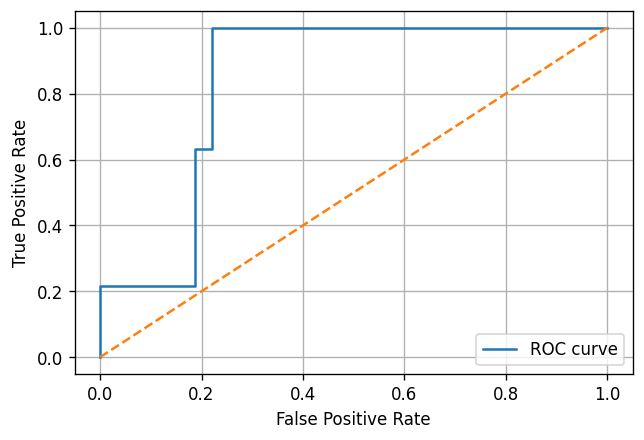

In [37]:
def cal_auc(lp_met: np.ndarray, Scores: np.ndarray):
    fpr, tpr, thresholds = metrics.roc_curve(y_true=lp_met, y_score=Scores, pos_label=1, drop_intermediate=False)

    roc_point = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'thresholds': thresholds})
    print(roc_point)

    # print('AUC : %s'%metrics.auc(fpr,tpr))
    print('AUC: %s' % metrics.roc_auc_score(y_true=lp_met, y_score=Scores))

    fig = plt.figure(dpi=120)
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('')
    plt.legend()
    plt.grid()

    plt.show()

predicted = np.array([x for x in predicted_test_list])
target = np.array([x for x in target_test_list])
#lp_met = np.array(['1', '1', '0', '1', '1'])
#Scores = np.array([0.9, 0.8, 0.7, 0.6, 0.55])

cal_auc(target, predicted)

## Results & Discussion